<a href="https://colab.research.google.com/github/MaxSMCON/Group07/blob/main/Group_7_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# !pip install xlrd -U


In [2]:
pip install bubble_plot

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
import re
from bubble_plot.bubble_plot import bubble_plot

# to make this notebook's output stable across runs
np.random.seed(10086)

def check_data_balance(series, style="seaborn-pastel"):
  with plt.style.context(style):
    unique = series.value_counts()
    display(unique) #show unique value counts of the target
    plt.pie(unique, explode=[0.05]*len(unique), labels=unique.index, autopct='%1.1f%%'); #plot a pie chart for the target to see if data are balanced

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.decomposition import PCA
from functools import wraps
import inspect
def initializer(func): #https://stackoverflow.com/questions/1389180/automatically-initialize-instance-variables
    names, varargs, keywords, defaults = inspect.getfullargspec(func)[:4]
    @wraps(func)
    def wrapper(self, *args, **kargs):
        for name, arg in list(zip(names[1:], args)) + list(kargs.items()):
            setattr(self, name, arg)

        for name, default in zip(reversed(names), reversed(defaults)):
            if not hasattr(self, name):
                setattr(self, name, default)

        func(self, *args, **kargs)
    return wrapper

In [4]:
# !pip install pandas==1.2.0 --force
pd.__version__


'1.3.5'


# Import Data
---


In [5]:

url = "https://raw.githubusercontent.com/MaxSMCON/Group07/main/Census%20Data%20Adula%20Over%2050K.csv"
data = pd.read_csv(url)
data.head()

Age         Work Class  fnlwgt: continuous.    Eduction  Education Number  \
0   39          State-gov                77516   Bachelors                13   
1   50   Self-emp-not-inc                83311   Bachelors                13   
2   38            Private               215646     HS-grad                 9   
3   53            Private               234721        11th                 7   
4   28            Private               338409   Bachelors                13   

        Martial Status          Occupation    Relationship    Race      Sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   Capital Gain  Capital Loss  Hours Per Wk   Native Country Income Level   
0          2174             0             40   United-States         <=50K  
1             0             0             13   United-States         <=50K  
2             0             0             40   United-States         <=50K  
3             0             0             40   United-States         <=50K  
4             0             0             40            Cuba         <=50K

In [6]:
#column label cleanup
data.columns=data.columns.str.rstrip()
data.columns=data.columns.str.replace(' ','_')
data.head(2)

Age         Work_Class  fnlwgt:_continuous.    Eduction  Education_Number  \
0   39          State-gov                77516   Bachelors                13   
1   50   Self-emp-not-inc                83311   Bachelors                13   

        Martial_Status        Occupation    Relationship    Race    Sex  \
0        Never-married      Adm-clerical   Not-in-family   White   Male   
1   Married-civ-spouse   Exec-managerial         Husband   White   Male   

   Capital_Gain  Capital_Loss  Hours_Per_Wk  Native_Country Income_Level  
0          2174             0            40   United-States        <=50K  
1             0             0            13   United-States        <=50K

In [7]:
df=data

In [8]:
df.dtypes

Age                     int64
Work_Class             object
fnlwgt:_continuous.     int64
Eduction               object
Education_Number        int64
Martial_Status         object
Occupation             object
Relationship           object
Race                   object
Sex                    object
Capital_Gain            int64
Capital_Loss            int64
Hours_Per_Wk            int64
Native_Country         object
Income_Level           object
dtype: object

# Project Plan
<li> Clean the data
<li> Feature Contributions
<li> pipeline
<li> Classifiers - Random Forest
<li> Cross validation
<li> Grid Search, hyper
<li> ROC, presic
<li> Clustering - Create new targets
<li> Story - presentation

```
# This is formatted as code
```



## Jing & Ramila to take care of missing values

Jing's comments - Columns contain “?” are : Work class, Occupation  and Native Country. Hours per week is range from 1 to 99, I think it doesn’t make sense for too little or too many. Ages are a range from 17 to 90.

Ramila's Comment  - I have replace the "?" values with Other adn validated if hte code works 
Also i have added the code to create two classification >60 hours or  <60 hours if you need to use the new Column called Hour Class. 

In [9]:
#Pre Validation Data
df['Work_Class'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Work_Class, dtype: int64

In [10]:
#Code to replace "?" with Other for the three Columns 
df = df.replace({'Occupation': '\?', 'Native_Country': '\?','Work_Class':'\?' }, 
    {'Occupation': 'Other', 'Native_Country': 'Other', 'Work_Class': 'Other'}, regex=True)



In [11]:
# Evaluating if the ? is gone using Value Counts
df['Work_Class'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 Other                1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Work_Class, dtype: int64

In [12]:
df['Occupation'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Other                1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64

In [13]:
df['Native_Country'].value_counts()

 United-States                 29170
 Mexico                          643
 Other                           583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

In [14]:
#Code to Create a column that defined the Hours worked Per week classified as More and Less than 60 Hours per Week 

df["Hours_Per_Wk"] = pd.to_numeric(df["Hours_Per_Wk"])


In [15]:
df['Hour_Class']=pd.cut(df['Hours_Per_Wk'],bins=[0,60,99],labels=["Less","More"])

In [16]:
df['Hour_Class'].value_counts()

Less    31451
More     1110
Name: Hour_Class, dtype: int64

## Panthea clean column headers

*   List item
*   List item



## David
<li> Prepare the story

## 

```
# This is formatted as code
```



## Sivi
<li> Clustering

# New Section



```SIVI to do Data visualization 
# This is formatted as code
```



Data Visualization-Sivi


In [17]:
import seaborn as sns

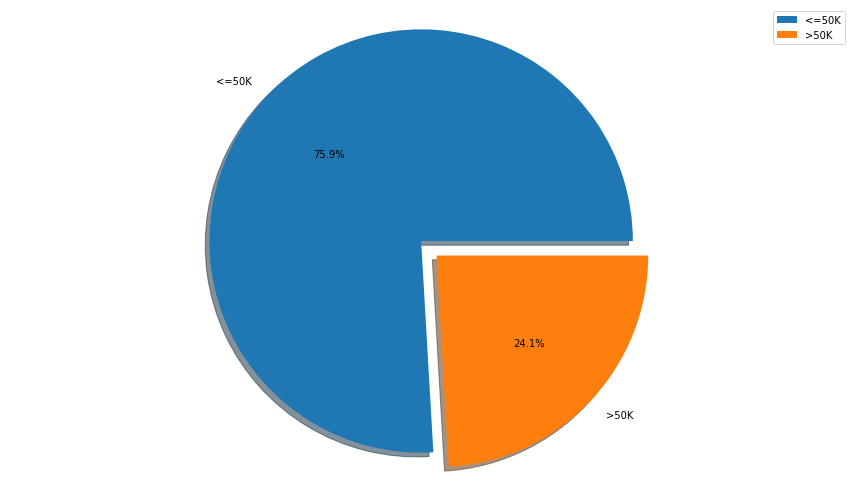

In [18]:
#Let’s check out the Proportion of target variable in dataset!
explode = (0.1,0)  
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.pie(data['Income_Level'].value_counts(), explode=explode,labels=['<=50K','>50K'], autopct='%1.1f%%',
        shadow=True)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.legend()
plt.show()

In [19]:
fig = px.histogram(df, x = 'Income_Level', 
                   y = 'fnlwgt:_continuous.',
                   color = 'Sex',
                    # marginal = 'box',
                    opacity = 1,
                   barmode = 'group',
                   histfunc= 'count'
             )
fig.update_layout(
        autosize=False,
    width=400,
    height=400,
    title_text='Income & Number of Records', 
    yaxis_title_text='Number of Records', # xaxis label
    xaxis_title_text='Income Level', # yaxis label
    bargap=0.2,
    bargroupgap=0.1
    )
fig.show();

In [20]:
fig = px.histogram(df, x = 'Income_Level', 
                   y = 'fnlwgt:_continuous.',
                   color = 'Sex',
                    # marginal = 'box',
                    opacity = 1,
                   barmode = 'group'
             )
fig.update_layout(
        autosize=False,
    width=400,
    height=400,
    title_text='Income & Weight Distribution', 
    yaxis_title_text='Fnl weight', # xaxis label
    xaxis_title_text='Income_Level', # yaxis label
    bargap=0.2,
    bargroupgap=0.1
    )
fig.show();

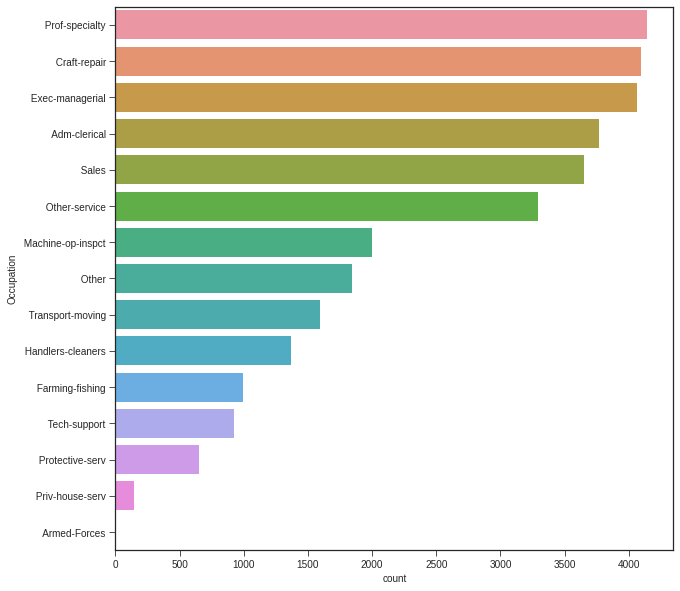

In [21]:
#Marital Status
fig=plt.figure(figsize=(10,10))
plt.style.use('seaborn-ticks')
sns.countplot(y='Occupation',data=df,order=df['Occupation'].value_counts().index)

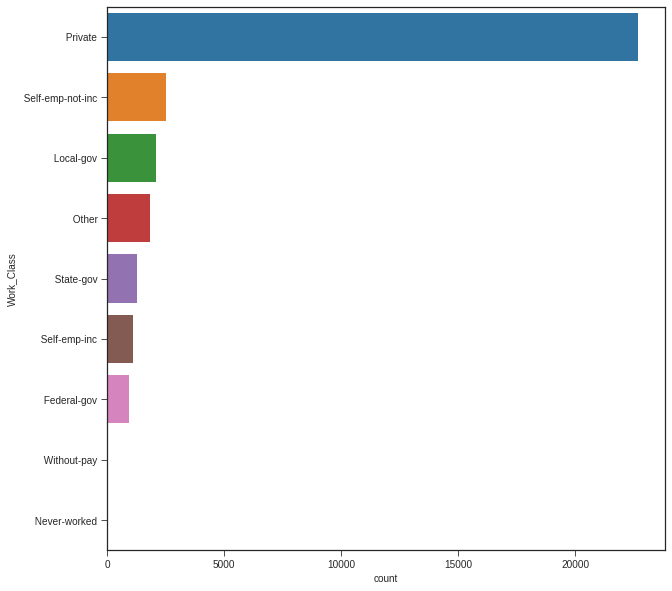

In [22]:
fig=plt.figure(figsize=(10,10))
plt.style.use('seaborn-ticks')
sns.countplot(y='Work_Class',data=df,order=df['Work_Class'].value_counts().index)

In [23]:
df['Eduction'].replace(' Preschool', 'dropout',inplace=True)
df['Eduction'].replace(' 10th', 'dropout',inplace=True)
df['Eduction'].replace(' 11th', 'dropout',inplace=True)
df['Eduction'].replace(' 12th', 'dropout',inplace=True)
df['Eduction'].replace(' 1st-4th', 'dropout',inplace=True)
df['Eduction'].replace(' 5th-6th', 'dropout',inplace=True)
df['Eduction'].replace(' 7th-8th', 'dropout',inplace=True)
df['Eduction'].replace(' 9th', 'dropout',inplace=True)
df['Eduction'].replace(' HS-Grad', 'HighGrad',inplace=True)
df['Eduction'].replace(' HS-grad', 'HighGrad',inplace=True)
df['Eduction'].replace(' Some-college', 'CommunityCollege',inplace=True)
df['Eduction'].replace(' Assoc-acdm', 'CommunityCollege',inplace=True)
df['Eduction'].replace(' Assoc-voc', 'CommunityCollege',inplace=True)
df['Eduction'].replace(' Bachelors', 'Bachelors',inplace=True)
df['Eduction'].replace(' Masters', 'Masters',inplace=True)
df['Eduction'].replace(' Prof-school', 'Masters',inplace=True)
df['Eduction'].replace(' Doctorate', 'Doctorate',inplace=True)
df[['Eduction', 'Education_Number']].groupby(['Eduction'], as_index=False).mean().sort_values(by='Education_Number', ascending=False)

Eduction  Education_Number
2         Doctorate         16.000000
4           Masters         14.250544
0         Bachelors         13.000000
1  CommunityCollege         10.360986
3          HighGrad          9.000000
5           dropout          5.602398

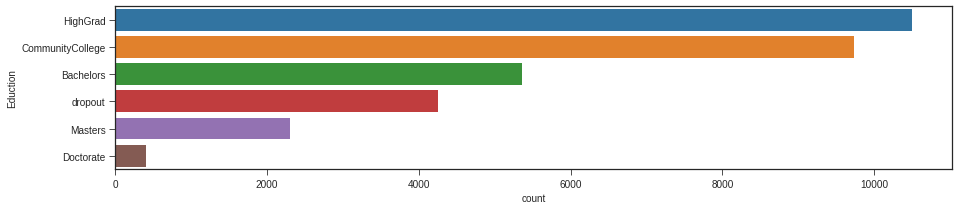

In [24]:
fig = plt.figure(figsize=(15,3))
plt.style.use('seaborn-ticks')
sns.countplot(y="Eduction", data=df, order=df['Eduction'].value_counts().index)

In [25]:
df['Martial_Status'].value_counts()

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Martial_Status, dtype: int64

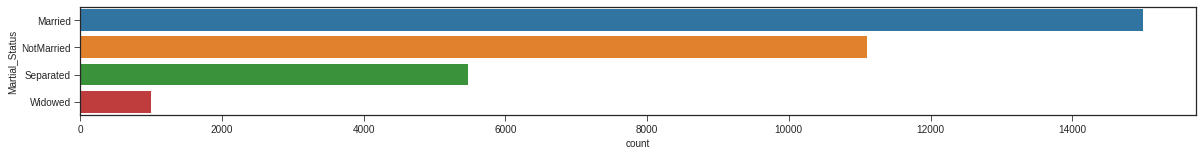

In [26]:
df['Martial_Status'].replace(' Never-married', 'NotMarried',inplace=True)
df['Martial_Status'].replace([' Married-AF-spouse'], 'Married',inplace=True)
df['Martial_Status'].replace([' Married-civ-spouse'], 'Married',inplace=True)
df['Martial_Status'].replace([' Married-spouse-absent'], 'NotMarried',inplace=True)
df['Martial_Status'].replace([' Separated'], 'Separated',inplace=True)
df['Martial_Status'].replace([' Divorced'], 'Separated',inplace=True)
df['Martial_Status'].replace([' Widowed'], 'Widowed',inplace=True)

fig = plt.figure(figsize=(20,2))
plt.style.use('seaborn-ticks')
sns.countplot(y="Martial_Status", data=df, order=df['Martial_Status'].value_counts().index)

In [27]:
# make the age variable discretized 
df['age_bin'] = pd.cut(df['Age'], 50)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



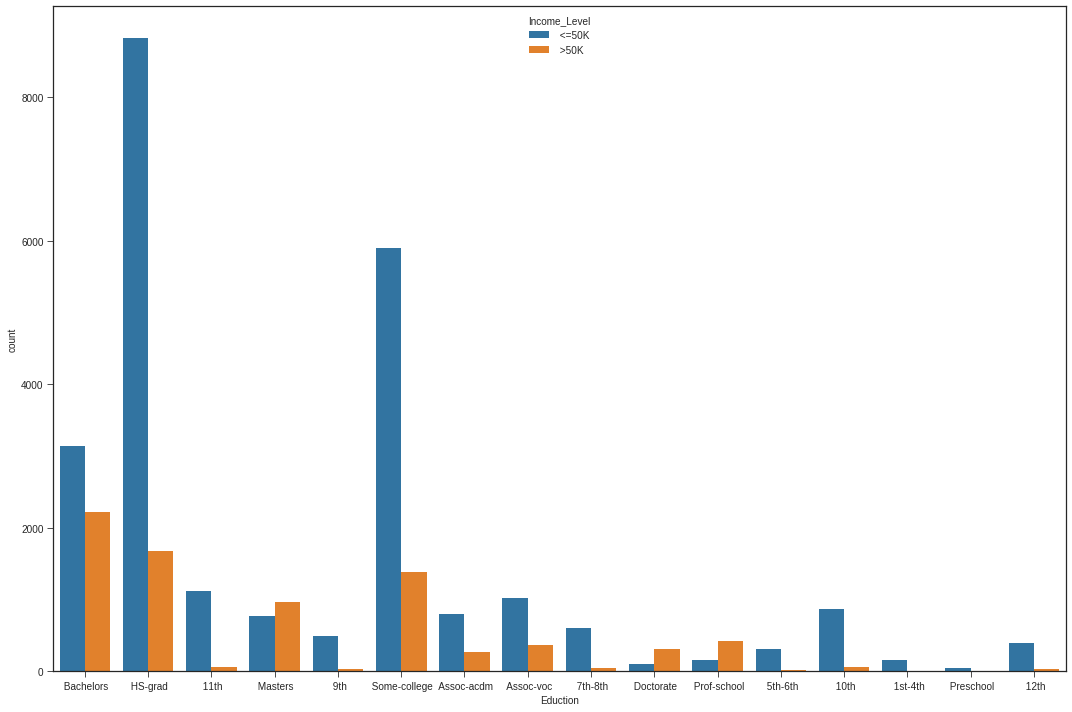

In [28]:
fig = plt.figure(figsize=(15,10))

sns.countplot('Eduction', hue='Income_Level', data=data)
plt.tight_layout()
plt.show()

#Tableau Graph

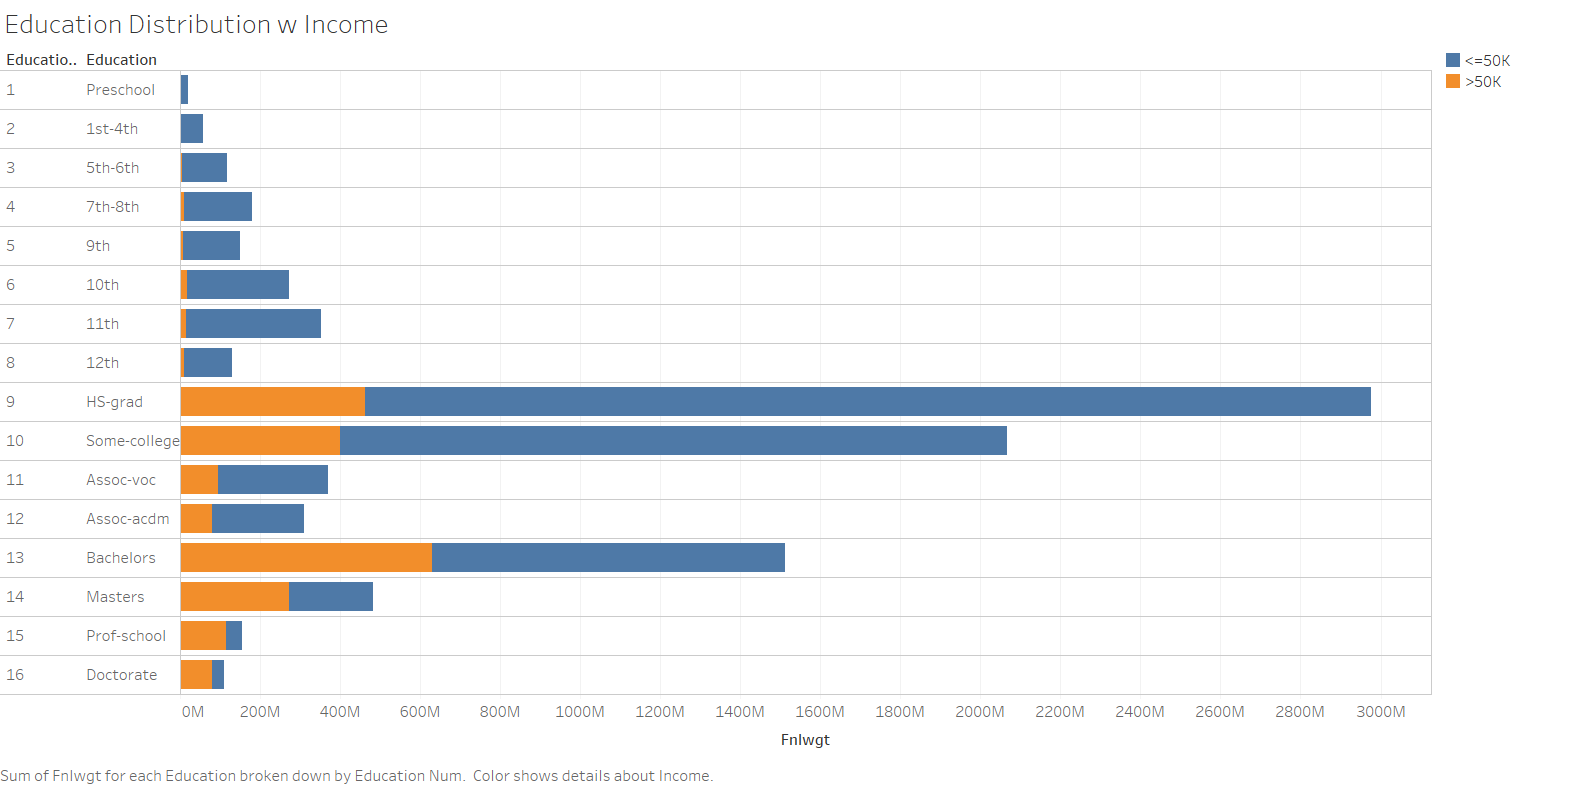

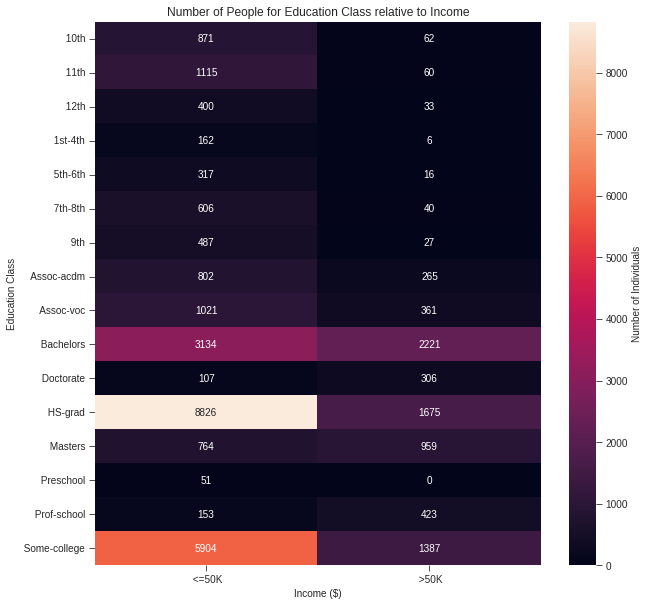

In [29]:
# Heat map
plt.figure(figsize=[10,10])
 
ct_counts = data.groupby(['Eduction', 'Income_Level']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'Eduction', columns = 'Income_Level', values = 'count').fillna(0)

sns.heatmap(ct_counts, annot = True, fmt = '.0f', cbar_kws = {'label' : 'Number of Individuals'})
plt.title('Number of People for Education Class relative to Income')
plt.xlabel('Income ($)')
plt.ylabel('Education Class');

In the graph above, we can see that people with education cHS-grad and some college  make up the highest portion in the dataset. Also, we notice that people with Higher education usually make >50k as income in the statistics we have in the dataset, unlike lesser education classes where they usually make <=50k as income.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



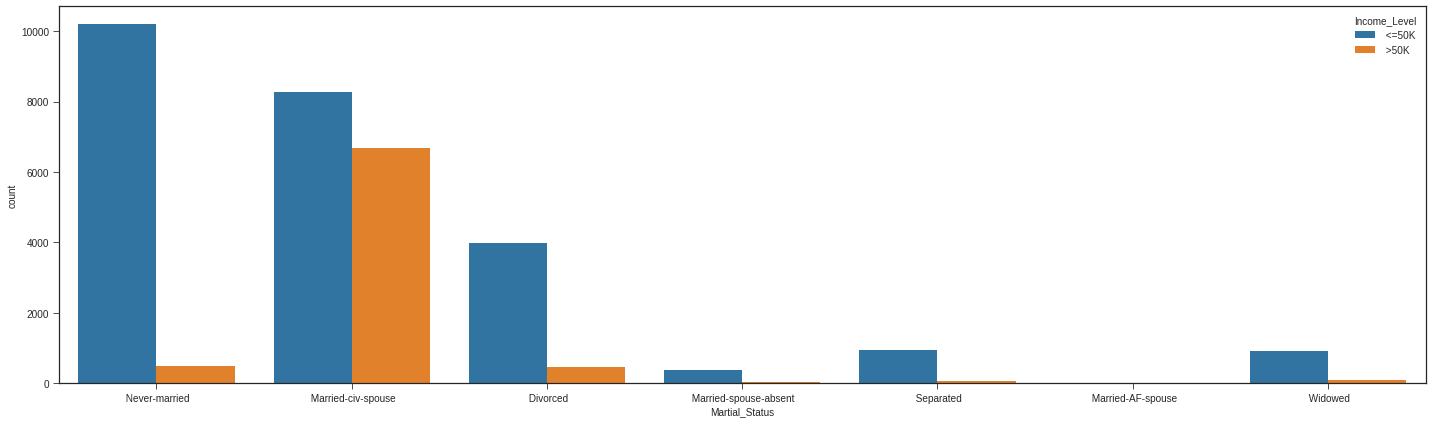

In [30]:
ig = plt.figure(figsize=(20,6))

sns.countplot('Martial_Status', hue='Income_Level', data=data)
plt.tight_layout()
plt.show()

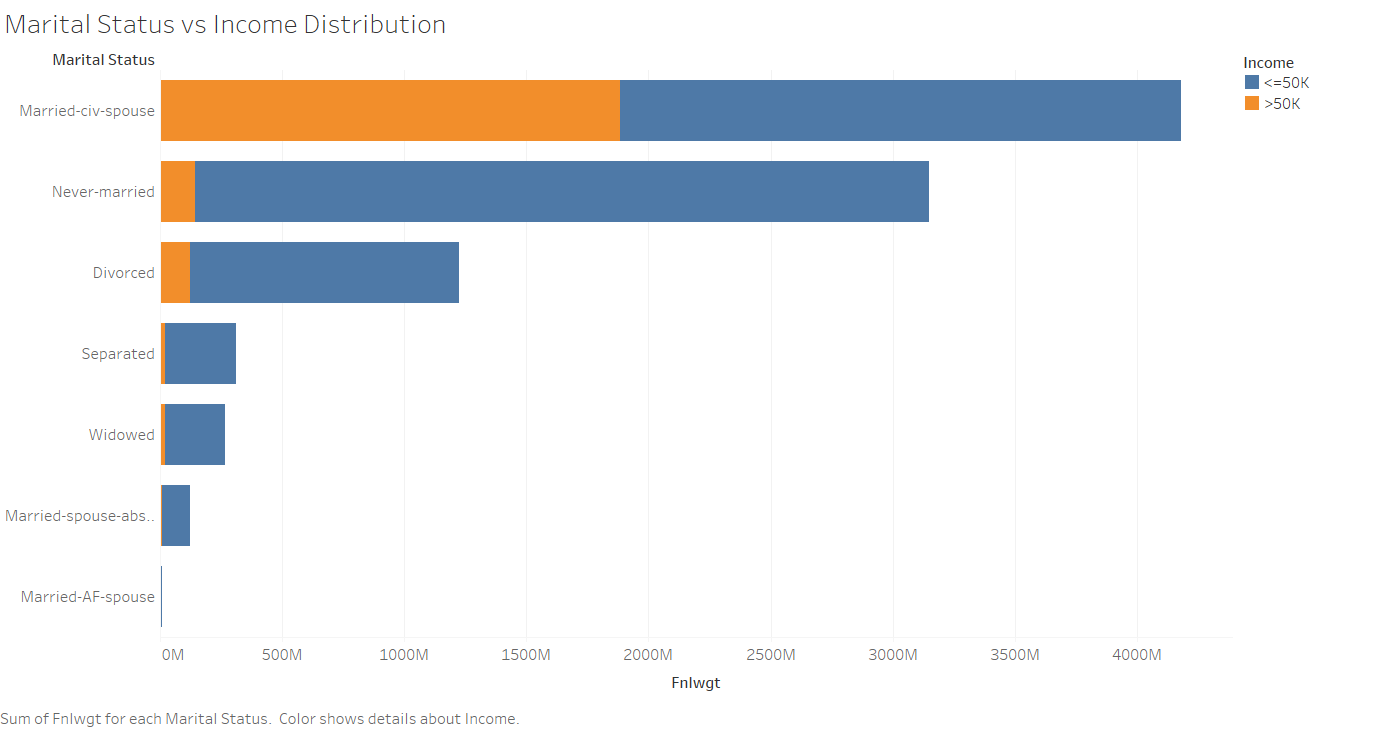Tableau Graph

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



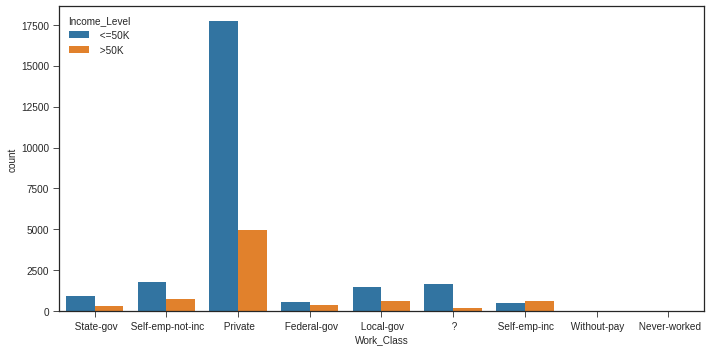

In [31]:
fig = plt.figure(figsize=(10,5))
sns.countplot('Work_Class', hue='Income_Level', data=data)
plt.tight_layout()
plt.show()

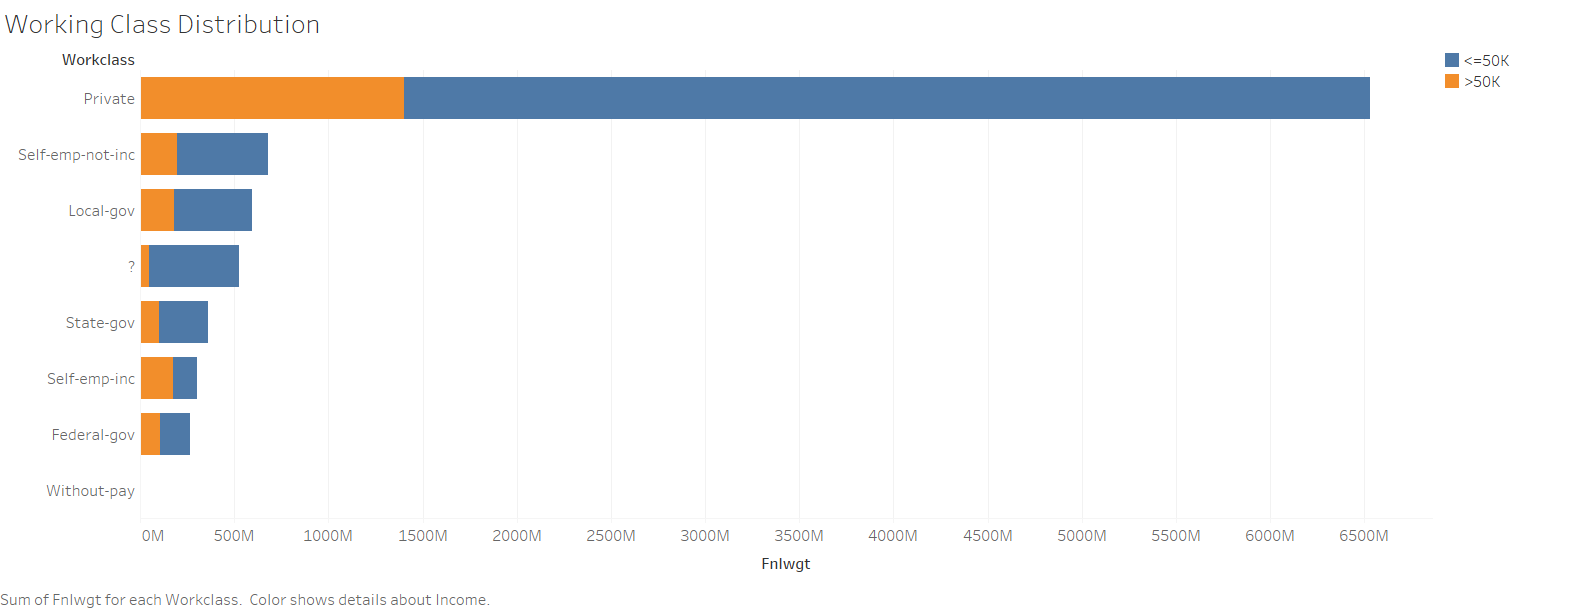

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



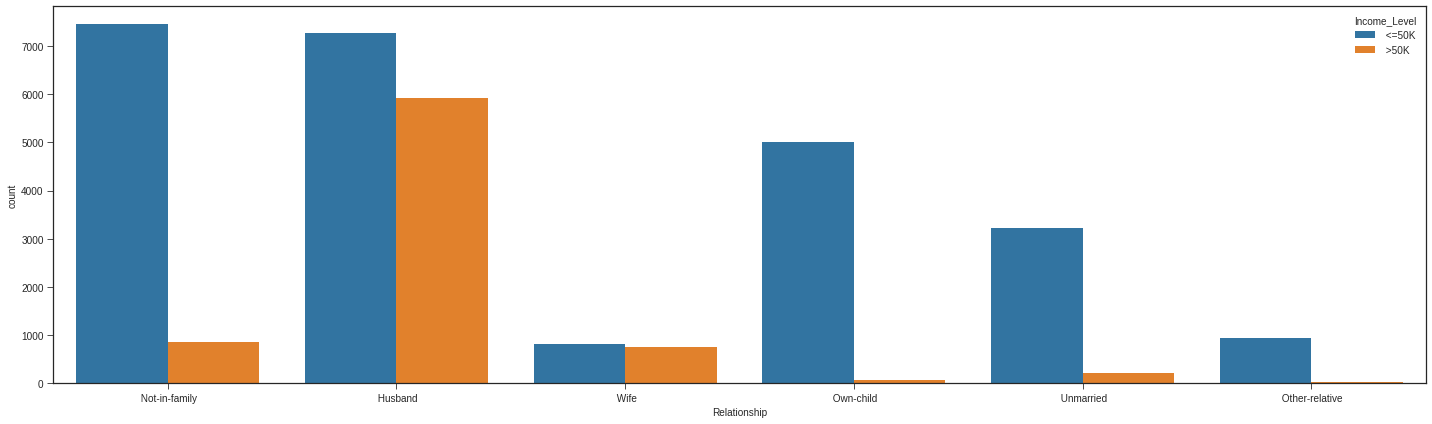

In [32]:
fig = plt.figure(figsize=(20,6))
sns.countplot('Relationship', hue='Income_Level', data=data)
plt.tight_layout()
plt.show()

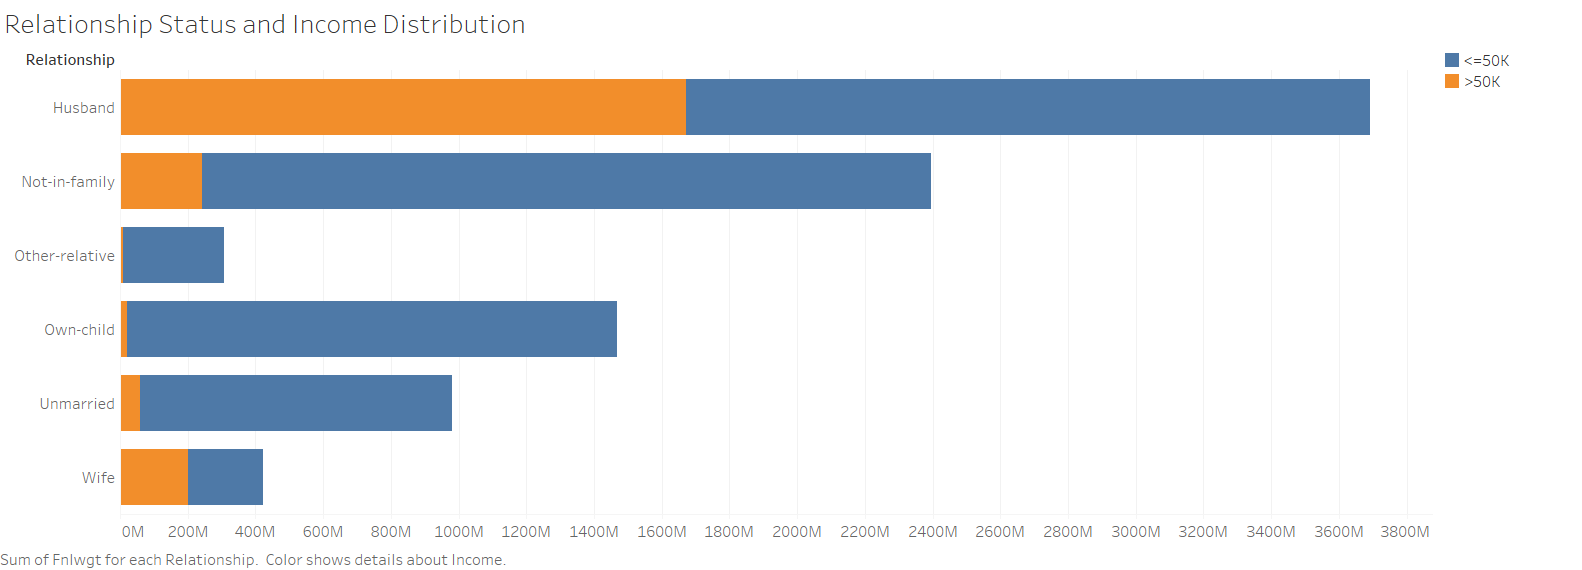

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



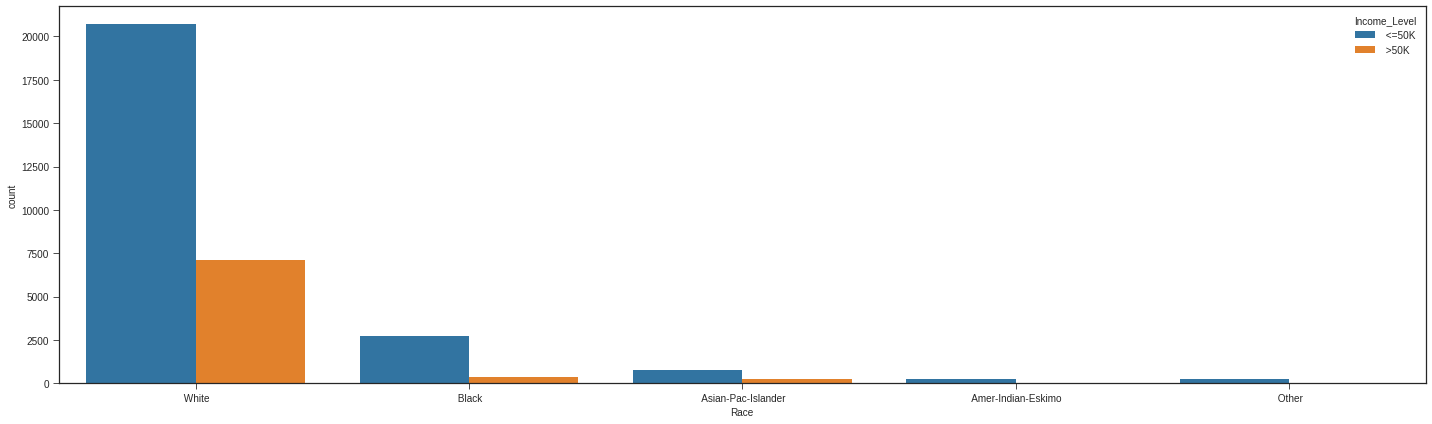

In [33]:
fig = plt.figure(figsize=(20,6))
sns.countplot('Race', hue='Income_Level', data=data)
plt.tight_layout()
plt.show()

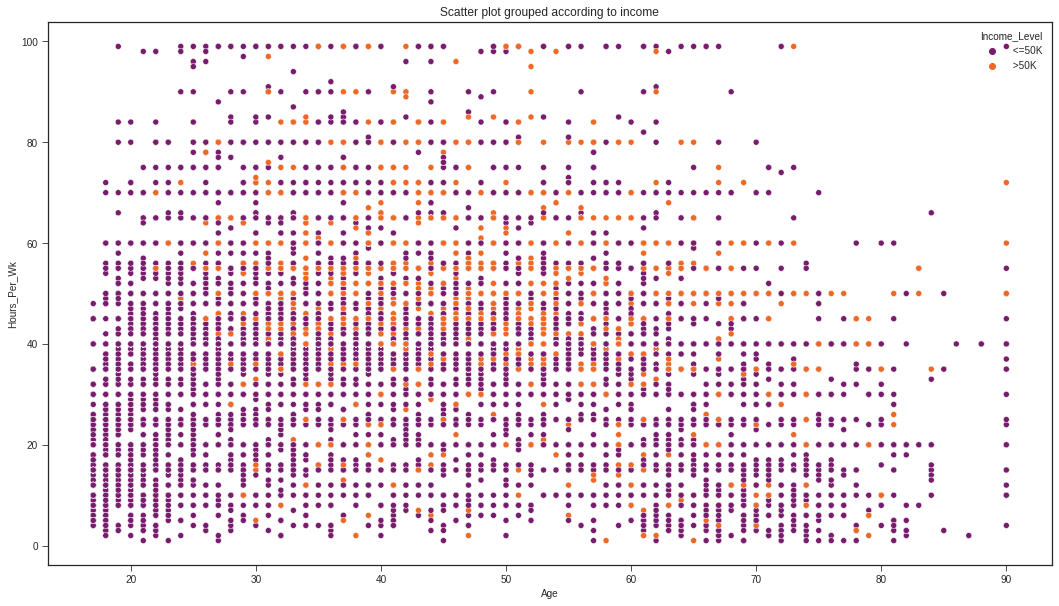

In [35]:
plt.figure(figsize=(18, 10))  
sns.scatterplot(x='Age', y='Hours_Per_Wk', hue='Income_Level', data=data,palette="inferno")  
plt.title('Scatter plot grouped according to income')  
plt.show()  

In [36]:
df.columns

Index(['Age', 'Work_Class', 'fnlwgt:_continuous.', 'Eduction',
       'Education_Number', 'Martial_Status', 'Occupation', 'Relationship',
       'Race', 'Sex', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Wk',
       'Native_Country', 'Income_Level', 'Hour_Class', 'age_bin'],
      dtype='object')

In [37]:
## Tableau screen
## can be recreacted using seaborn count age
fig = px.histogram(df, x = 'Age', 
                   y = 'fnlwgt:_continuous.',
                   color = 'Income_Level',
                   marginal = 'box',
                   barmode = 'overlay',
                   opacity = 0.75)
fig.update_layout(title_text='Age & Weight Distribution', 
    xaxis_title_text='Age', # xaxis label
    yaxis_title_text='Fnl weight', # yaxis label
    )
fig.show();

In [38]:
df["fnlwgt:_continuous."].sum()

6179373392

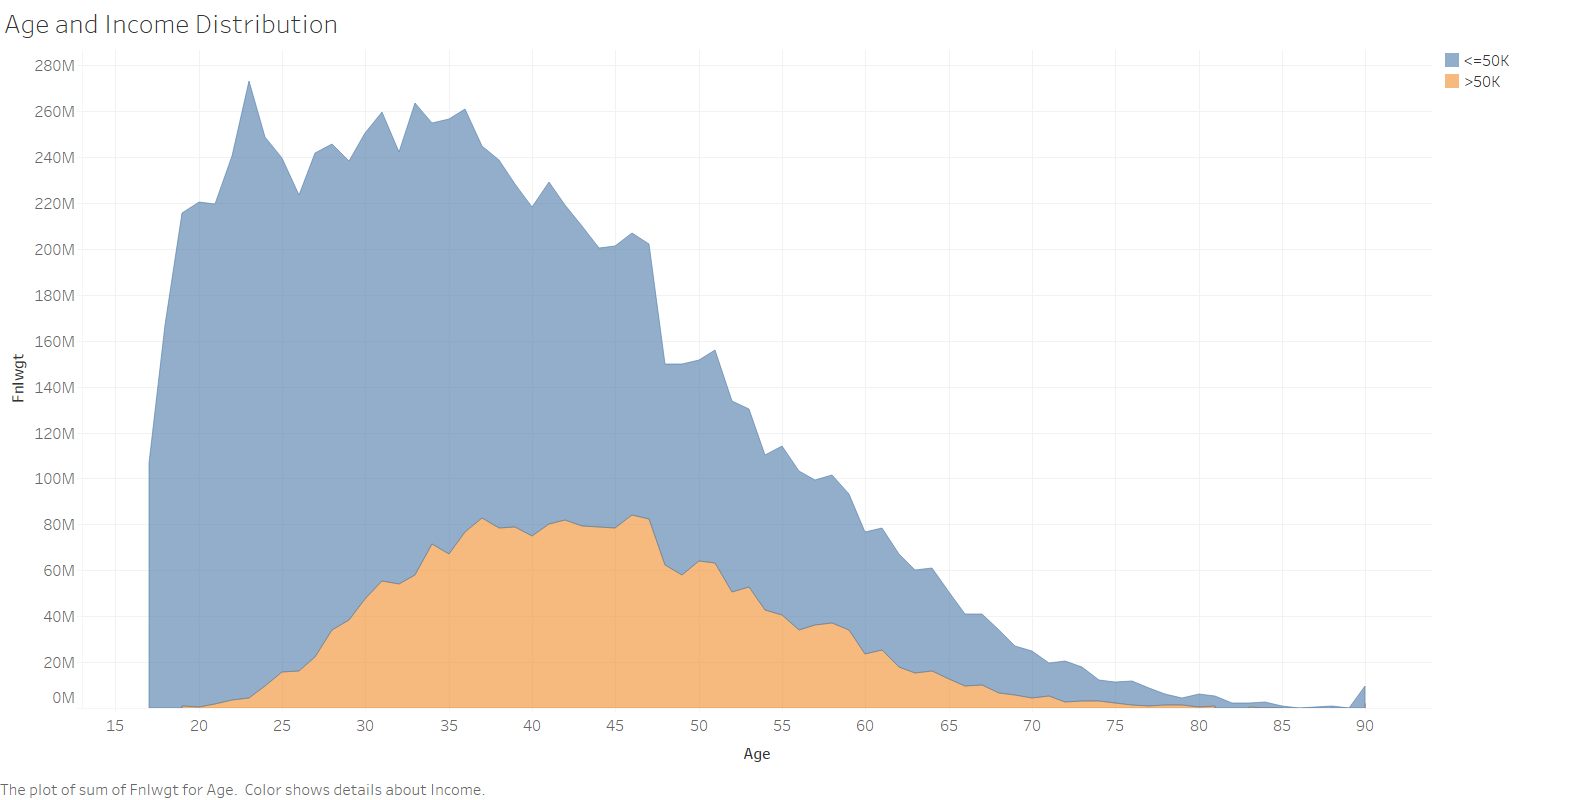

In [39]:
fig = px.histogram(df, y = 'Occupation', 
                   x = 'fnlwgt:_continuous.',
                   color = 'Income_Level',
                    marginal = 'box',
                    opacity = 1,
                   barmode = 'overlay'
             )
fig.update_layout(title_text='Occupation & Weight Distribution', 
    yaxis_title_text='Occupation', # xaxis label
    xaxis_title_text='Fnl weight', # yaxis label
    bargap=0.2,
    bargroupgap=0.1
    )
fig.show();

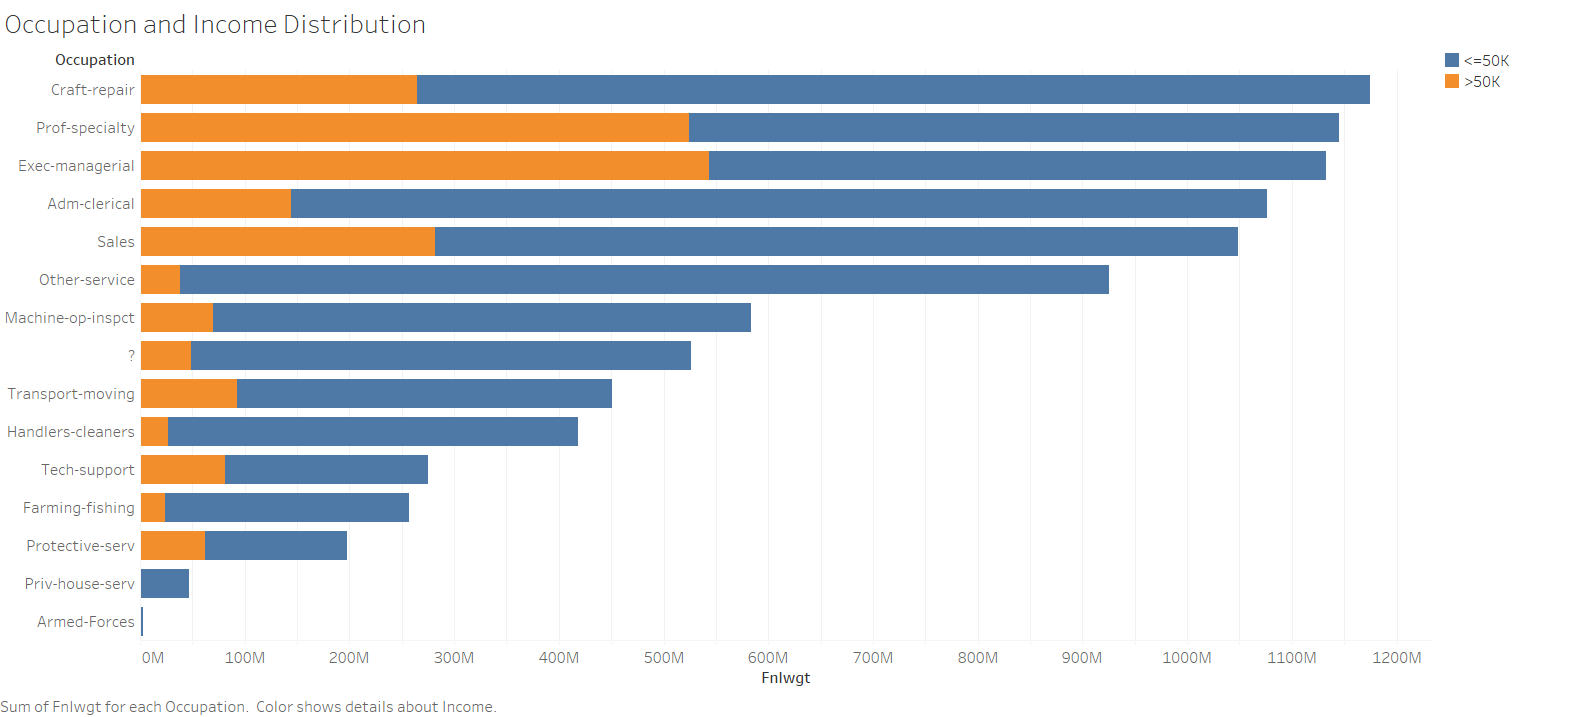

In [40]:
fig = px.histogram(df, x = 'Sex', 
                   y = 'fnlwgt:_continuous.',
                   color = 'Income_Level',
                    # marginal = 'box',
                    opacity = 1,
                   barmode = 'group'
             )
fig.update_layout(
        autosize=False,
    width=500,
    height=600,
    title_text='Sex & Weight Distribution', 
    yaxis_title_text='Sex', # xaxis label
    xaxis_title_text='Fnl weight', # yaxis label
    bargap=0.2,
    bargroupgap=0.1
    )
fig.show();

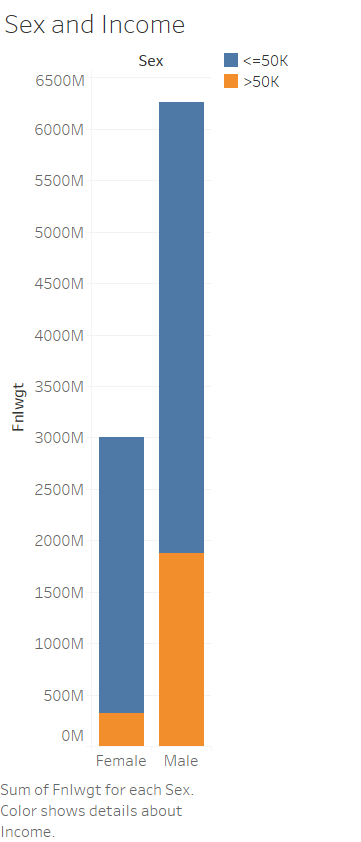

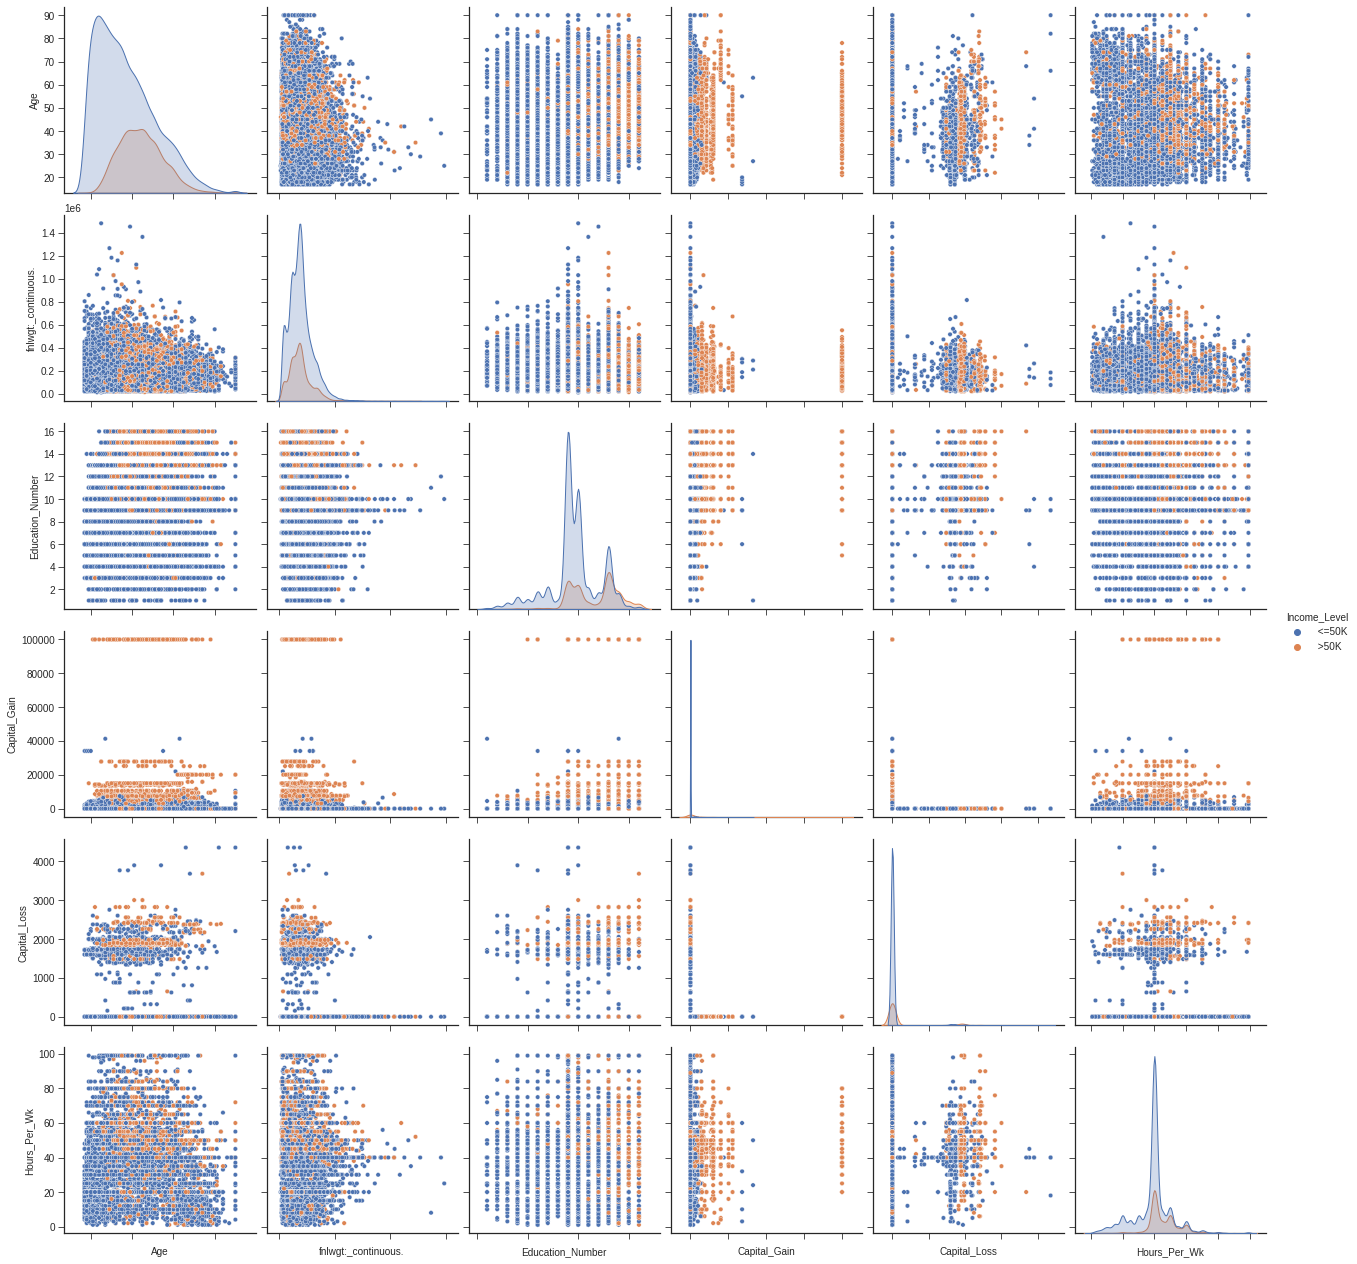

In [41]:
#pair plots of entire dataset
pp = sns.pairplot(df, hue = 'Income_Level', palette = 'deep', 
                  height=3, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=20) )
pp.set(xticklabels=[]);

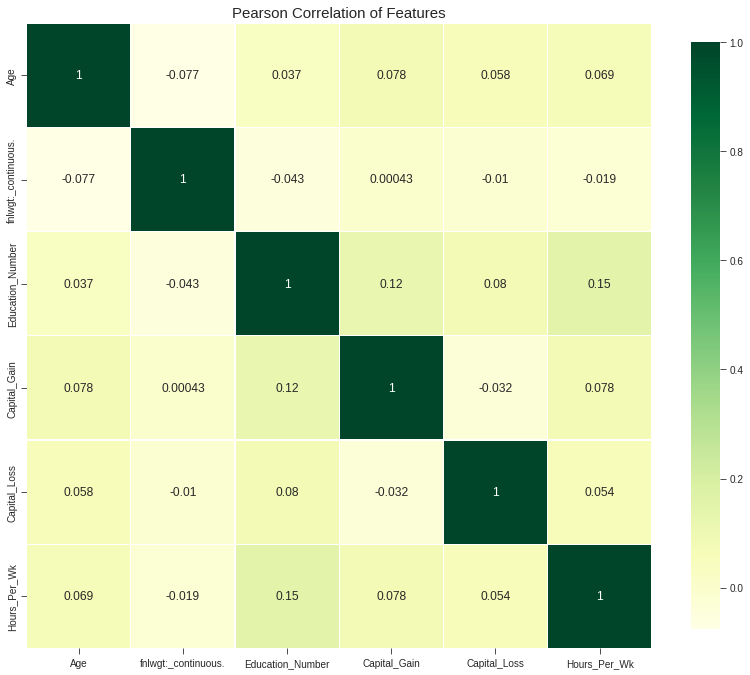

In [42]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = "YlGn",
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df)

In [43]:
# One Hot Encodes all labels before Machine Learning
one_hot_cols = df.columns.tolist()
one_hot_cols.remove('Income_Level')
dataset_bin_enc = pd.get_dummies(df, columns=one_hot_cols)

dataset_bin_enc.head()

Income_Level  Age_17  Age_18  Age_19  Age_20  Age_21  Age_22  Age_23  \
0        <=50K       0       0       0       0       0       0       0   
1        <=50K       0       0       0       0       0       0       0   
2        <=50K       0       0       0       0       0       0       0   
3        <=50K       0       0       0       0       0       0       0   
4        <=50K       0       0       0       0       0       0       0   

   Age_24  Age_25  ...  age_bin_(75.4, 76.86]  age_bin_(76.86, 78.32]  \
0       0       0  ...                      0                       0   
1       0       0  ...                      0                       0   
2       0       0  ...                      0                       0   
3       0       0  ...                      0                       0   
4       0       0  ...                      0                       0   

   age_bin_(78.32, 79.78]  age_bin_(79.78, 81.24]  age_bin_(81.24, 82.7]  \
0                       0                       0                      0   
1                       0                       0                      0   
2                       0                       0                      0   
3                       0                       0                      0   
4                       0                       0                      0   

   age_bin_(82.7, 84.16]  age_bin_(84.16, 85.62]  age_bin_(85.62, 87.08]  \
0                      0                       0                       0   
1                      0                       0                       0   
2                      0                       0                       0   
3                      0                       0                       0   
4                      0                       0                       0   

   age_bin_(87.08, 88.54]  age_bin_(88.54, 90.0]  
0                       0                      0  
1                       0                      0  
2                       0                      0  
3                       0                      0  
4                       0                      0  

[5 rows x 22184 columns]

In [44]:
# Label Encode all labels
dataset_con_enc = df.apply(LabelEncoder().fit_transform)

dataset_con_enc.head()

Age  Work_Class  fnlwgt:_continuous.  Eduction  Education_Number  \
0   22           7                 2671         0                12   
1   33           6                 2926         0                12   
2   21           4                14086         3                 8   
3   36           4                15336         5                 6   
4   11           4                19355         0                12   

   Martial_Status  Occupation  Relationship  Race  Sex  Capital_Gain  \
0               1           0             1     4    1            25   
1               0           3             0     4    1             0   
2               2           5             1     4    1             0   
3               0           5             0     2    1             0   
4               0          10             5     2    0             0   

   Capital_Loss  Hours_Per_Wk  Native_Country  Income_Level  Hour_Class  \
0             0            39              39             0           0   
1             0            12              39             0           0   
2             0            39              39             0           0   
3             0            39              39             0           0   
4             0            39               4             0           0   

   age_bin  
0       15  
1       22  
2       14  
3       24  
4        7

Feature importance

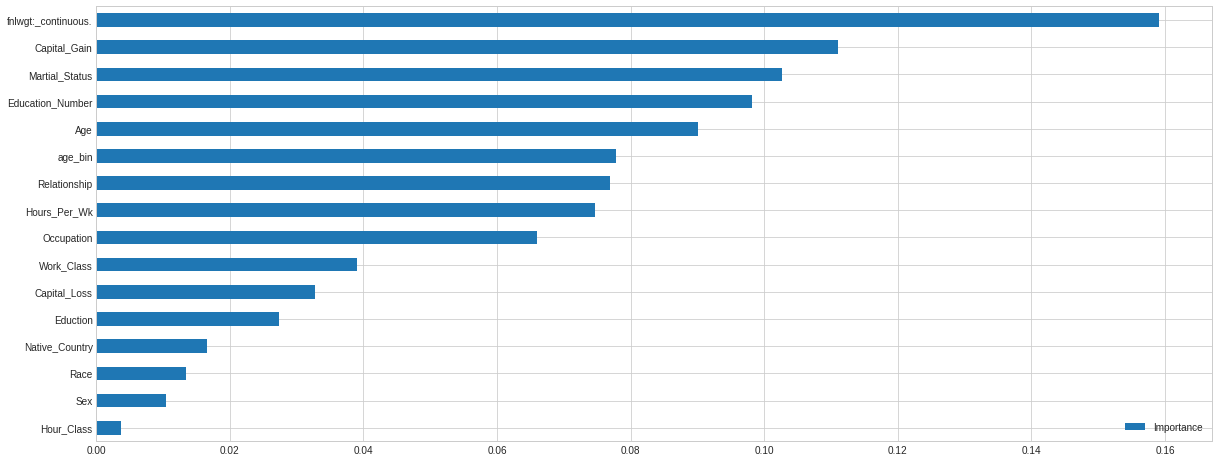

In [45]:

clf = RandomForestClassifier()
clf.fit(dataset_con_enc.drop('Income_Level', axis=1), dataset_con_enc['Income_Level'])

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=dataset_con_enc.drop('Income_Level', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

In [46]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [47]:
# Import

In [48]:
# df['Native Country '] = df['Native Country '].replace(['?'],['other'])


In [49]:
# df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", skiprows=1, header=0, index_col=0)
# df

df.columns

Index(['Age', 'Work_Class', 'fnlwgt:_continuous.', 'Eduction',
       'Education_Number', 'Martial_Status', 'Occupation', 'Relationship',
       'Race', 'Sex', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Wk',
       'Native_Country', 'Income_Level', 'Hour_Class', 'age_bin'],
      dtype='object')

## Definition of Target Column and Predictors

In [50]:
# for dataset in df:
#   df.loc[df["Income_Level"] == '<=50K' , 'Inc_Lvl' = 0
#   df.loc[df["Income_Level"] == '>50K' , 'Inc_Lvl' = 1
#   df['not_single'] = df['not_single'].astype(int)       

In [51]:
TARGET = ['Income_Level']
columns_nom_categorical = [ 'Work_Class', 'Eduction',
      #  'Education_Number', 
       'Martial_Status', 'Occupation', 'Relationship', 'Hour_Class',
       'Race', 'Sex',  'Native_Country', 'age_bin',  ]
contin_col = ['Age', 'Hours_Per_Wk', 'Education_Number']       

In [52]:
TARGET = 'Income_Level'
columns_predictors = [col for col in df.columns if col not in [TARGET]]
columns_numerical = [col for col in columns_predictors if col not in (columns_nom_categorical) ]
print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_nom_categorical: {columns_nom_categorical}")
# print(f"columns_ord_categorical: {columns_ord_categorical}")
print(f"columns_numerical: {columns_numerical}")

TARGET: Income_Level
columns_predictors: ['Age', 'Work_Class', 'fnlwgt:_continuous.', 'Eduction', 'Education_Number', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Wk', 'Native_Country', 'Hour_Class', 'age_bin']
columns_nom_categorical: ['Work_Class', 'Eduction', 'Martial_Status', 'Occupation', 'Relationship', 'Hour_Class', 'Race', 'Sex', 'Native_Country', 'age_bin']
columns_numerical: ['Age', 'fnlwgt:_continuous.', 'Education_Number', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Wk']


## Pipeline
<li> OneHot Encoder
<li> Standard Scaler

In [53]:
# from sklearn import preprocessing

# categorical = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
# for feature in categorical:
#         le = preprocessing.LabelEncoder()
#         X_train[feature] = le.fit_transform(X_train[feature])
#         X_test[feature] = le.transform(X_test[feature])

In [54]:
from sklearn.pipeline import Pipeline #each pipeline can have multiple steps
from sklearn.compose import ColumnTransformer #for selecting specific columns and transforming them with individual pipelines
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler #specific transformations we want to use in our pipelines

pipeline_categorical = Pipeline([
  ('onehot', OneHotEncoder(handle_unknown="ignore")),
])

pipeline_numerical = Pipeline([
  ('scaler', MinMaxScaler()),
])

pipeline_full = ColumnTransformer([
  ("categorical", pipeline_categorical, columns_nom_categorical),
  ("numerical", pipeline_numerical, contin_col)
])

#### Lebel Encoder

In [55]:
from sklearn.pipeline import Pipeline #each pipeline can have multiple steps
from sklearn.compose import ColumnTransformer #for selecting specific columns and transforming them with individual pipelines
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, LabelEncoder #specific transformations we want to use in our pipelines

pipeline_categorical = Pipeline([
  ('label', LabelEncoder()),
])

pipeline_numerical = Pipeline([
  ('scaler', MinMaxScaler()),
])

pipeline_full_label = ColumnTransformer([
  ("categorical", pipeline_categorical, columns_nom_categorical),
  ("numerical", pipeline_numerical, contin_col)
])

In [56]:
X = df[columns_predictors]
y = df[TARGET]
display(X.head())
display(y.head())

Age         Work_Class  fnlwgt:_continuous.   Eduction  Education_Number  \
0   39          State-gov                77516  Bachelors                13   
1   50   Self-emp-not-inc                83311  Bachelors                13   
2   38            Private               215646   HighGrad                 9   
3   53            Private               234721    dropout                 7   
4   28            Private               338409  Bachelors                13   

  Martial_Status          Occupation    Relationship    Race      Sex  \
0     NotMarried        Adm-clerical   Not-in-family   White     Male   
1        Married     Exec-managerial         Husband   White     Male   
2      Separated   Handlers-cleaners   Not-in-family   White     Male   
3        Married   Handlers-cleaners         Husband   Black     Male   
4        Married      Prof-specialty            Wife   Black   Female   

   Capital_Gain  Capital_Loss  Hours_Per_Wk  Native_Country Hour_Class  \
0          2174             0            40   United-States       Less   
1             0             0            13   United-States       Less   
2             0             0            40   United-States       Less   
3             0             0            40   United-States       Less   
4             0             0            40            Cuba       Less   

          age_bin  
0   (38.9, 40.36]  
1  (49.12, 50.58]  
2   (37.44, 38.9]  
3   (52.04, 53.5]  
4  (27.22, 28.68]

0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: Income_Level, dtype: object

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=123, 
                                                    stratify=None) #stratified sampling based on the target
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (26048, 16)
X_test.shape: (6513, 16)
y_train.shape: (26048,)
y_test.shape: (6513,)


In [59]:
# X_train[columns_nom_categorical]
# pipeline_categorical.fit_transform(X_train[columns_nom_categorical]).toarray().shape


In [60]:
# X_train.head(5)

Age Work_Class  fnlwgt:_continuous.          Eduction  \
17064   19    Private               219300  CommunityCollege   
18434   58    Private               116901          HighGrad   
3294    43    Private               220589          HighGrad   
31317   23    Private                50953  CommunityCollege   
4770    18    Private               130849           dropout   

       Education_Number Martial_Status        Occupation    Relationship  \
17064                10     NotMarried             Sales       Own-child   
18434                 9      Separated     Other-service       Unmarried   
3294                  9      Separated   Exec-managerial       Unmarried   
31317                10     NotMarried      Tech-support   Not-in-family   
4770                  7     NotMarried     Other-service       Own-child   

         Race      Sex  Capital_Gain  Capital_Loss  Hours_Per_Wk  \
17064   White   Female             0             0            25   
18434   White   Female             0             0            25   
3294    White   Female             0             0            40   
31317   White   Female             0             0            40   
4770    White   Female             0             0             8   

       Native_Country Hour_Class          age_bin  
17064   United-States       Less   (18.46, 19.92]  
18434   United-States       Less   (57.88, 59.34]  
3294    United-States       Less   (41.82, 43.28]  
31317   United-States       Less    (22.84, 24.3]  
4770    United-States       Less  (16.927, 18.46]

In [61]:
pipeline_full.fit

<bound method ColumnTransformer.fit of ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Work_Class', 'Eduction', 'Martial_Status',
                                  'Occupation', 'Relationship', 'Hour_Class',
                                  'Race', 'Sex', 'Native_Country', 'age_bin']),
                                ('numerical',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['Age', 'Hours_Per_Wk', 'Education_Number'])])>

In [62]:
X_train.dtypes

Age                       int64
Work_Class               object
fnlwgt:_continuous.       int64
Eduction                 object
Education_Number          int64
Martial_Status           object
Occupation               object
Relationship             object
Race                     object
Sex                      object
Capital_Gain              int64
Capital_Loss              int64
Hours_Per_Wk              int64
Native_Country           object
Hour_Class             category
age_bin                category
dtype: object

In [63]:
pipeline_numerical
# columns_numerical

Pipeline(steps=[('scaler', MinMaxScaler())])

In [64]:
pipeline_full.fit(X_train)
X_train_transformed = pipeline_full.transform(X_train)
X_test_transformed = pipeline_full.transform(X_test)
print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")


X_train_transformed.shape: (26048, 143)
X_test_transformed.shape: (6513, 143)


In [67]:
pipeline_full.fit_transform(X_train)

<26048x143 sparse matrix of type '<class 'numpy.float64'>'
	with 338259 stored elements in Compressed Sparse Row format>

In [66]:
# X_train_transformed_nom = pipeline_categorical.fit_transform(X_train)

TypeError: ignored

In [ ]:
X_train_transformed_nom

In [ ]:
X_train_transformed

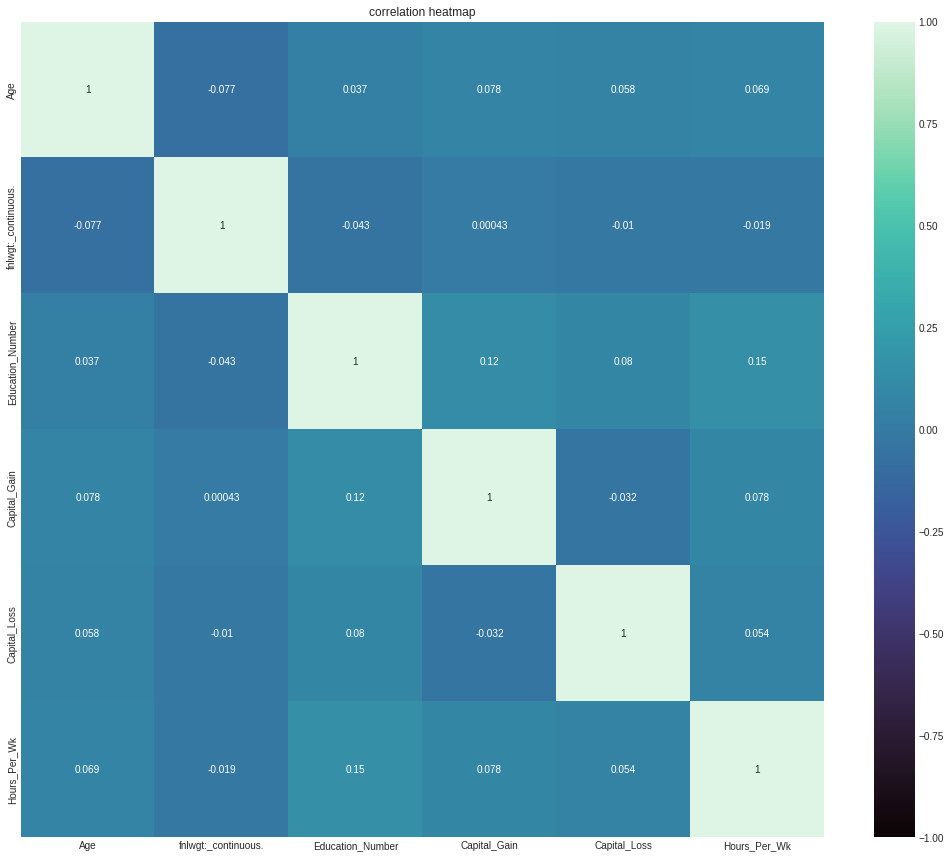

In [69]:
corr = df.corr()

plt.figure(figsize = (18,15))
sns.heatmap(corr, annot = True, vmin = -1.0, cmap = 'mako')
plt.title('correlation heatmap')
plt.show();

In [74]:
# X_train[columns_nom_categorical]
# pipeline_categorical.fit_transform(X_train[columns_nom_categorical]).toarray().shape

## Train Models

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler


In [72]:
models = {
    LogisticRegression(n_jobs = -1): "   Logistic Regression",
    SVC():                "           Support Vector Machine",
    MLPClassifier():       "                  Neural Network",
    # KNeighborsClassifier(n_jobs=3): "                            KNN",
    RandomForestClassifier():"      Random Forest Classifier"
}

for model in models.keys():
    model.fit(X_train_transformed, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [73]:

for model , name in models.items():
    print(name+": {:.2f}%".format(model.score(X_test_transformed, y_test)*100))
    # print(name+": {:.2f}%".format(model.classification_report(y_test, X_test_transformed))) 

   Logistic Regression: 83.86%
           Support Vector Machine: 83.37%
                  Neural Network: 81.38%
      Random Forest Classifier: 82.04%


In [75]:
models.items()

dict_items([(LogisticRegression(n_jobs=-1), '   Logistic Regression'), (SVC(), '           Support Vector Machine'), (MLPClassifier(), '                  Neural Network'), (RandomForestClassifier(), '      Random Forest Classifier')])

In [ ]:
# ## Income Level Distribution - MILD inbalance
# f = df.groupby(['Income_Level'])['Income_Level'].count()
# df.plot.pie(figsize=(5,5), autopct="%.2f")

## Random Forest on Whole Dataset

In [76]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_transformed, y_train)

RandomForestClassifier()

In [77]:
%%time
y_pred = rfc.predict(X_test_transformed)
print ("Classification Report")
print(classification_report(y_test, y_pred))
print ("Confusion Report")
print(confusion_matrix(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

       <=50K       0.87      0.91      0.89      4927
        >50K       0.66      0.57      0.61      1586

    accuracy                           0.82      6513
   macro avg       0.77      0.74      0.75      6513
weighted avg       0.82      0.82      0.82      6513

Confusion Report
[[4469  458]
 [ 683  903]]
CPU times: user 452 ms, sys: 0 ns, total: 452 ms
Wall time: 454 ms


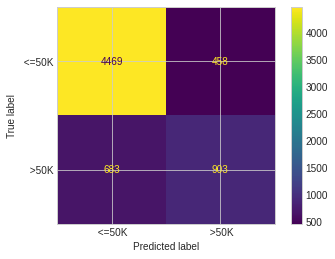

In [78]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rfc.classes_, )
disp.plot()

In [79]:
pca = PCA(n_components=.95)
transf_df=pca.fit_transform(dataset_con_enc[dataset_con_enc.columns[2:]])
transf_df.shape

(32561, 1)

In [80]:
X_train.shape

(26048, 16)

## Random Forest

In [81]:
# X_train=transf_df[:60000,:]
# X_test=transf_df[60000:,:]
# y_train=df.iloc[:60000,1]
# y_test=df.iloc[60000:,1]

In [82]:
X_train_transformed.shape

(26048, 143)

In [83]:
%%time
rfc.fit(X_train_transformed, y_train)


CPU times: user 23.1 s, sys: 17.5 ms, total: 23.2 s
Wall time: 23.1 s


RandomForestClassifier()

In [84]:
predictions = rfc.predict(X_test_transformed)

In [85]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       <=50K       0.87      0.91      0.89      4927
        >50K       0.66      0.57      0.61      1586

    accuracy                           0.82      6513
   macro avg       0.76      0.74      0.75      6513
weighted avg       0.82      0.82      0.82      6513



In [86]:
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



<Figure size 2000x1500 with 0 Axes>

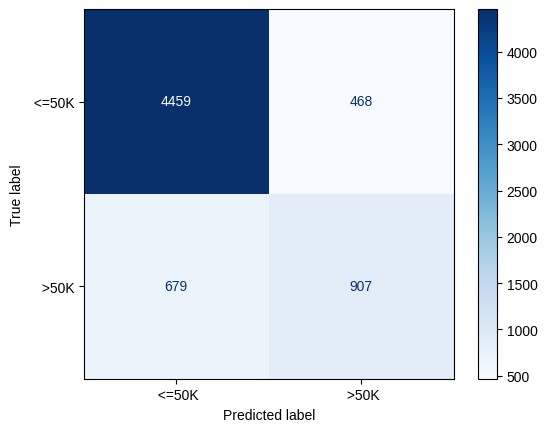

In [87]:
with plt.style.context("default"):
    fig=plt.figure(figsize=(20,15));
    ax=plot_confusion_matrix(rfc,X_test_transformed,y_test,values_format="",cmap="Blues");

### GridSearch for RandomForest

In [88]:

# estimators = [4, 5, 10, 20, 50]
# for i in estimators:
#     model = RandomForestClassifier(random_state = 123, n_estimators=i)
#     model.fit(X_train_transformed, y_train)
#     y_pred = model.predict(X_test_transformed)
#     y_pred_proba = model.predict_proba(X_test_transformed)
#     scores = cross_val_score(model, X_test_transformed, y_test, cv = 5, scoring='neg_mean_squared_error')
#     print("Random Forest estimator = ", i)
#     print("accuracy_score: {:2.2%}".format(accuracy_score(y_test, y_pred)))
#     # print("precision_score: {:2.2%}".format( precision_score(y_test, y_pred)))
#     # print("recall_score: {:2.2%}".format(recall_score(y_test, y_pred)))
#     print("f1_score:{:2.2}".format(f1_score(y_test, y_pred)))
#     print("roc_auc_score: {:2.2}".format(roc_auc_score(y_test, y_pred_proba[:,1])))
#     print('____________')

## T-SNE dataset reduction


In [89]:
%%time
from sklearn.manifold import TSNE
reducer = TSNE(n_components=2, n_jobs = -1)
X_reduced = reducer.fit_transform(X_train_transformed)
display(X_reduced.shape)
display(X_reduced)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(26048, 2)

array([[-58.1936    , -44.047462  ],
       [-69.16804   ,  32.584503  ],
       [-59.963284  ,  37.020992  ],
       ...,
       [-10.339475  , -44.374058  ],
       [ -0.56391317, -31.915672  ],
       [-64.788536  , -11.273963  ]], dtype=float32)

CPU times: user 10min 14s, sys: 5.85 s, total: 10min 20s
Wall time: 5min 48s


In [90]:
print(X_train.shape)
X_reduced.shape

(26048, 16)


(26048, 2)

In [131]:
fig = px.scatter(x=X_reduced[:,0], y=X_reduced[:,1], color=y_train, title="TSNE", opacity = 0.5)
fig.update_layout(coloraxis_colorbar=dict(title=TARGET), height=600, width = 600)
fig.update_yaxes(scaleanchor = "x")
fig.show()

PCA Reducer 

## Random Forest on Reduced dataset

In [92]:
%%time
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_reduced, y_train)

CPU times: user 3.88 s, sys: 18 ms, total: 3.9 s
Wall time: 3.89 s


In [93]:
%%time
reducer = TSNE(n_components=2, n_jobs = -1)
X_test_reduced = reducer.fit_transform(X_test_transformed)
display(X_test_reduced.shape)
display(X_test_reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(6513, 2)

array([[-28.78436  ,  61.004753 ],
       [ -5.6414127,  55.680817 ],
       [ 41.94957  , -22.358402 ],
       ...,
       [ 72.52397  ,  20.50328  ],
       [-36.903767 ,  56.31723  ],
       [ 32.778217 ,  30.574604 ]], dtype=float32)

CPU times: user 2min 3s, sys: 7.39 s, total: 2min 10s
Wall time: 1min 9s


In [94]:
print(X_test_reduced.shape)


(6513, 2)


#### Evaluation F1, precision etc

In [95]:
# %%time
y_pred = rfc.predict(X_test_reduced)
print ("Classification Report")
print(classification_report(y_test, y_pred))
print ("Confusion Report")
print(confusion_matrix(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

       <=50K       0.79      0.84      0.82      4927
        >50K       0.38      0.30      0.33      1586

    accuracy                           0.71      6513
   macro avg       0.58      0.57      0.57      6513
weighted avg       0.69      0.71      0.70      6513

Confusion Report
[[4158  769]
 [1117  469]]


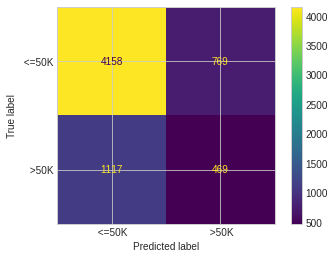

In [96]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rfc.classes_)
disp.plot()

## PCA Reducer

In [97]:
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model

In [98]:
X_train_transformed.shape

(26048, 143)

In [99]:
# from sklearn.decomposition import SparsePCA
# from sklearn.decomposition import PCA

# reducer = PCA(n_components = 0.95)
# X_reduced = reducer.fit_transform(X_train_transformed)
# display(X_reduced.shape)
# display(X_reduced)
# fig = px.scatter(x=X_reduced[:,0], y=X_reduced[:,1], color = y, title="PCA")
# fig.update_layout(height=1000)
# fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
# fig.show()

# Tuning Model
<li> Next Steps
<li> Panthea - Tuning hyper parameters - cross valdiation (precision, ROC), Gridsearch
<li> Unsuperivesd Learning to tune target

<li> Reduction of dimensionalty - apply this before classification


In [134]:
df = data.copy()

In [135]:
df.groupby([ 'Race'])['Age'].agg({'mean', 'count'})

count       mean
Race                                 
 Amer-Indian-Eskimo    311  37.173633
 Asian-Pac-Islander   1039  37.746872
 Black                3124  37.767926
 Other                 271  33.457565
 White               27816  38.769881

## Explore the data balance

In [102]:
# df['hours'] = df(df['Hours Per Wk']> 60, 'more', df['Hours Per Wk']<= 60, "less")

In [136]:
df.dtypes

Age                     int64
Work_Class             object
fnlwgt:_continuous.     int64
Eduction               object
Education_Number        int64
Martial_Status         object
Occupation             object
Relationship           object
Race                   object
Sex                    object
Capital_Gain            int64
Capital_Loss            int64
Hours_Per_Wk            int64
Native_Country         object
Income_Level           object
dtype: object

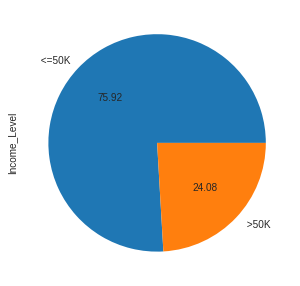

In [137]:
df = df.groupby(['Income_Level'])['Income_Level'].count()
df.plot.pie(figsize=(5,5), autopct="%.2f")
plt.show()

In [105]:
# df.groupby(['Race'])['Age'].agg({'mean', 'count'})

In [106]:
# df.groupby([ 'Native_Country'])['Age'].agg({'mean', 'count'})

In [138]:
df.isnull().sum()

0

## Grouping features into cat, cont categories

In [139]:
df.nunique()

2

In [109]:
target = ['Income Level']

contin_var = ["Age", 'fnlwgt: continuous.', 'Hours Per Wk ' ,'Capital Gain', 'Capital Loss', ]

cat_var= ["Work Class" , "Education Number", 'Education Number']

categ_string_var = ['Martial Status', 'Occupation', 'Relationship',
       'Race', 'Sex',]

In [110]:
# df.loc[:, contin_var + cat_var + categ_string_var].hist(bins = 50, figsize=(12, 8))
# plt.show()

## Decision Tree

### Hard Voting

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('knn', knn_clf) ],
    voting='hard')

voting_clf.fit(X_train_transformed, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, knn_clf, voting_clf):
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed);
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred));


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression 0.8386304314448026
RandomForestClassifier 0.8232765238753262
KNeighborsClassifier 0.8238906801781053


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



VotingClassifier 0.8340242591739597


### Soft Voting

In [112]:
%%time
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('knn', knn_clf) ],
    voting='soft')

for clf in (log_clf, rnd_clf, knn_clf, voting_clf):
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed);
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred));

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression 0.8386304314448026
RandomForestClassifier 0.820205742361431
KNeighborsClassifier 0.8238906801781053


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



VotingClassifier 0.8357131890066022
CPU times: user 1min 6s, sys: 275 ms, total: 1min 6s
Wall time: 1min 6s


### Bagging not transformed datasets

In [113]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=50,
    max_samples=90, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train_transformed, y_train)
y_pred = bag_clf.predict(X_test_transformed)
print(accuracy_score(y_test, y_pred))

0.8194380469829572


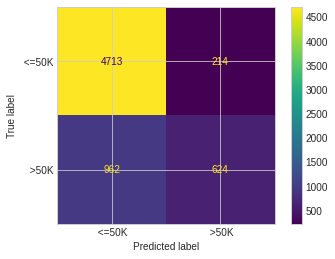

In [114]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rfc.classes_)
disp.plot()

### Random Forest

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

rnd_clf = RandomForestClassifier(n_estimators=50, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train_transformed, y_train)

y_pred = rnd_clf.predict(X_test_transformed)
print(accuracy_score(y_test, y_pred))

0.8215875940426839


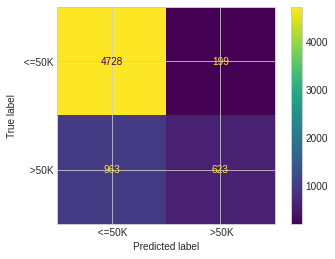

In [116]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rfc.classes_)
disp.plot()

## Extremely Randomized Trees

In [117]:
from sklearn.ensemble import ExtraTreesClassifier


forest = ExtraTreesClassifier(n_estimators=5)
forest.fit(X_train_transformed, y_train)
y_pred = forest.predict(X_test_transformed)
print(accuracy_score(y_test, y_pred))

0.8031629049593122


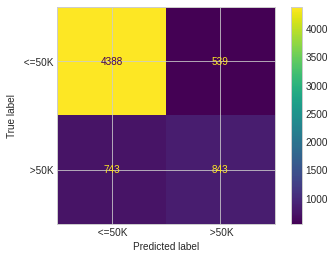

In [118]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rfc.classes_)
disp.plot()

## ADA BOOST

In [119]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train_transformed, y_train)
y_pred = ada_clf.predict(X_test_transformed)
print(accuracy_score(y_test, y_pred))

0.8413941348073085


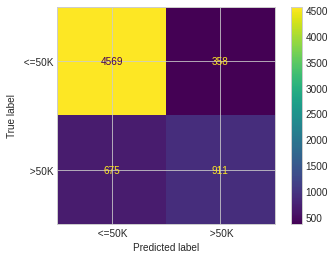

In [120]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rfc.classes_)
disp.plot()

### Gradient Boosting (Ramila)

In [121]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier( random_state = 42)
gb_clf.fit(X_train_transformed, y_train)
y_pred_gb =gb_clf.predict(X_test_transformed)


In [122]:
#Evaluate the Model 
gb_clf.score(X_test_transformed,y_test)


0.8378627360663289

In [123]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_gb)
# How many trees did the model create 
print (" Number of Trees Creates by the Model ", len(gb_clf.estimators_))
y_train_pred = gb_clf.predict_proba(X_train_transformed)[:,1]
y_test_pred = gb_clf.predict_proba(X_test_transformed)[:,1]


 Number of Trees Creates by the Model  100


In [124]:
print("AUC Train: {:.2f}%\nAUC Test: {:.2f}%".format(roc_auc_score(y_train, y_train_pred)*100,
                                                    roc_auc_score(y_test, y_test_pred)*100))


AUC Train: 89.99%
AUC Test: 89.52%


In [125]:
print("Accuracy Score: {:.2f}%".format(accuracy_score(y_test, y_pred_gb)*100))


Accuracy Score: 83.79%


### ADA Boost Classifier (Panthea)

In [126]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train_transformed)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train_transformed)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test_transformed)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test_transformed)))

In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train_transformed, y_train)
y_pred = ada_clf.predict(X_test_transformed)
evaluate_model(ada_clf)

Train Accuracy : 0.8393350737100738
Train Confusion Matrix:
[[18280  1513]
 [ 2672  3583]]
--------------------------------------------------
Test Accuracy : 0.8413941348073085
Test Confusion Matrix:
[[4569  358]
 [ 675  911]]
